<a href="https://colab.research.google.com/github/Sisynn/syesildal-cc2526/blob/main/CodingFinalAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 55.0 MB/s eta 0:00:00


In [ ]:
import glob #Glob all XYZ files

xyz_files = glob.glob("/content/dsgdb9nsd_*.xyz")
print("Found XYZ files:", len(xyz_files))


Found XYZ files: 133885


In [ ]:
import pandas as pd #Parse each file into descriptors + gap

descriptor_list = []

for file in xyz_files:
    with open(file) as f:
        lines = f.readlines()

    try:
        props = lines[0].split()  # first line = properties
        gap_h = float(props[-1])  # last number = HOMO-LUMO gap in Hartree
        gap_ev = gap_h * 27.2114  # convert to eV
    except:
        continue

    # Count atom types
    atoms = [line.split()[0] for line in lines[1:] if len(line.split()) >= 4]

    row = {
        "C": atoms.count("C"),
        "H": atoms.count("H"),
        "N": atoms.count("N"),
        "O": atoms.count("O"),
        "F": atoms.count("F"),
        "n_atoms": len(atoms),
        "gap": gap_ev
    }
    descriptor_list.append(row)

# Make DataFrame and save CSV
df = pd.DataFrame(descriptor_list)
df.to_csv("qm9_subset_small.csv", index=False)
print("Final molecules saved:", len(df))
df.head()


Final molecules saved: 133885


,C,H,N,O,F,n_atoms,gap
0,8,9,1,0,0,20,489.8052
1,6,10,2,1,0,21,517.0166
2,9,10,0,0,0,21,517.0166
3,8,12,0,1,0,23,571.4394
4,5,9,1,3,0,20,489.8052


In [ ]:
!ls -lh qm9_subset_small.csv
import pandas as pd
df_check = pd.read_csv("qm9_subset_small.csv")
print(len(df_check))
df_check.head()


-rw-r--r-- 1 root root 3.2M Jan  8 18:39 qm9_subset_small.csv
133885


,C,H,N,O,F,n_atoms,gap
0,8,9,1,0,0,20,489.8052
1,6,10,2,1,0,21,517.0166
2,9,10,0,0,0,21,517.0166
3,8,12,0,1,0,23,571.4394
4,5,9,1,3,0,20,489.8052


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the CSV again
df = pd.read_csv("qm9_subset_small.csv")
print("Number of molecules in dataset:", len(df))
df.head()

# Features: elemental counts + total atoms
X = df[["C", "H", "N", "O", "F", "n_atoms"]].values
# Target: HOMO-LUMO gap in eV
y = df["gap"].values

# Split into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Number of molecules in dataset: 61549


Epoch 1/50
3013/3013 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 59275.4336 - val_loss: 89.9349
Epoch 2/50
3013/3013 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 83.6901 - val_loss: 32.1030
Epoch 3/50
3013/3013 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 27.0289 - val_loss: 5.1261
Epoch 4/50
3013/3013 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 3.5203 - val_loss: 0.8587
Epoch 5/50
3013/3013 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5788 - val_loss: 0.2206
Epoch 6/50
3013/3013 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3408 - val_loss: 0.1574
Epoch 7/50
3013/3013 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3514 - val_loss: 0.1299
Epoch 8/50
3013/3013 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.3436 - val_loss: 0.0672
Epoch 9/50
3013/3013 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3411 - val_loss: 0.0430
Epoch 10/50
3013/3013 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.3372 - val_loss: 0.0347
Epoch 11/50
3013/3013 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.3330 - val_loss: 0.0295
Epoch 12/50
3013/3013

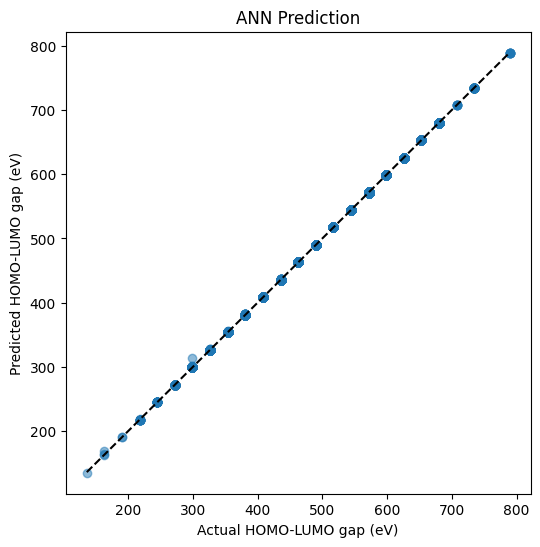

In [ ]:
import tensorflow as tf
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Define simple ANN
ann = tf.keras.models.Sequential([
    tf.keras.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)  # output: HOMO-LUMO gap
])

# Compile model with Adam optimizer and MSE loss
ann.compile(optimizer="adam", loss="mse")

# Train model for 50 epochs, batch size 32
ann.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.1)

# Predict on test set
y_pred_ann = ann.predict(X_test_scaled).flatten()

# Compute R² score
r2_ann = r2_score(y_test, y_pred_ann)
print("ANN R² score:", r2_ann)

# Parity plot: predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_ann, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="black")
plt.xlabel("Actual HOMO-LUMO gap (eV)")
plt.ylabel("Predicted HOMO-LUMO gap (eV)")
plt.title("ANN Prediction")
plt.show()


Random Forest R² score: 0.9999999927421283


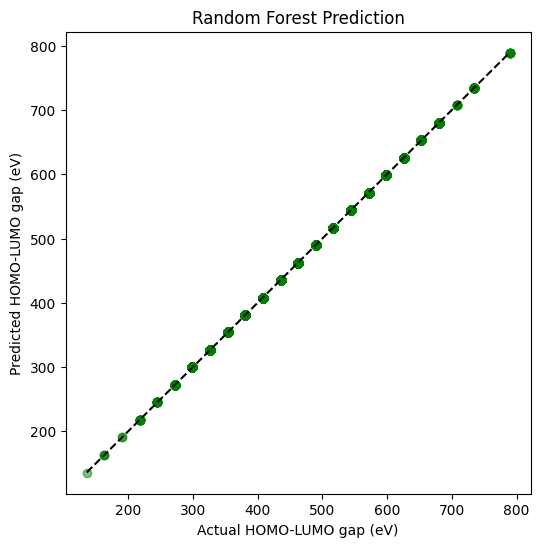

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest with 300 trees
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)

# Train model
rf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test_scaled)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest R² score:", r2_rf)

# Parity plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="black")
plt.xlabel("Actual HOMO-LUMO gap (eV)")
plt.ylabel("Predicted HOMO-LUMO gap (eV)")
plt.title("Random Forest Prediction")
plt.show()


KRR R² score: 0.9999837725255096


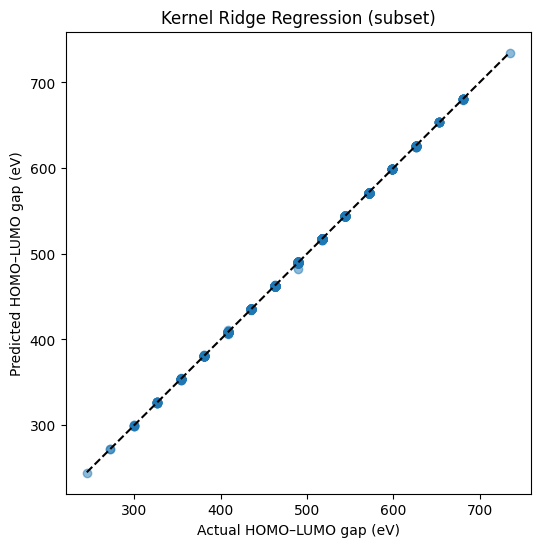

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

# Subsample dataset
df_krr = df.sample(n=5000, random_state=42)

X = df_krr[["C","H","N","O","F","n_atoms"]].values
y = df_krr["gap"].values

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scaling (MANDATORY for KRR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KRR model
krr = KernelRidge(
    kernel="rbf",
    alpha=1e-3,
    gamma=1e-2
)

krr.fit(X_train_scaled, y_train)

# Prediction
y_pred_krr = krr.predict(X_test_scaled)
r2_krr = r2_score(y_test, y_pred_krr)

print("KRR R² score:", r2_krr)

# Parity plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_krr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], "--", color="black")
plt.xlabel("Actual HOMO–LUMO gap (eV)")
plt.ylabel("Predicted HOMO–LUMO gap (eV)")
plt.title("Kernel Ridge Regression (subset)")
plt.show()
